In [1]:
HCP7T_Embedds_Path = '/data/SFIMJGC/PRJ_CognitiveStateDetection02/Scripts_HCP7T/Notebooks/EmbeddingResults/HCP7T_AWAKE_WL030s_LE100_Pearson_AllWin_3D_ManualClusterInfo.pkl'

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from utils.data_functions import compute_SWC
import seaborn as sns
from matplotlib.patches import Rectangle
from scipy.spatial.distance import squareform

In [3]:
HCP7T_Embedds_DF = pd.read_pickle(HCP7T_Embedds_Path)

In [4]:
HCP7T_Subjects = HCP7T_Embedds_DF.columns.get_level_values(0).unique()

In [5]:
from mpl_toolkits.mplot3d.axes3d import Axes3D, proj3d
import matplotlib.pyplot as plt

In [6]:
HCP7T_Partition_DF = pd.read_csv('/data/SFIMJGC/PRJ_CognitiveStateDetection02/PNAS2018_Notebooks/DPartit_AWAKE.csv').drop("Unnamed: 0", axis=1)
HCP7T_NClusters    = HCP7T_Partition_DF.max()+1
HCP7T_NClusters.head()

547046    3
118225    3
751550    4
195041    3
783462    4
dtype: int64

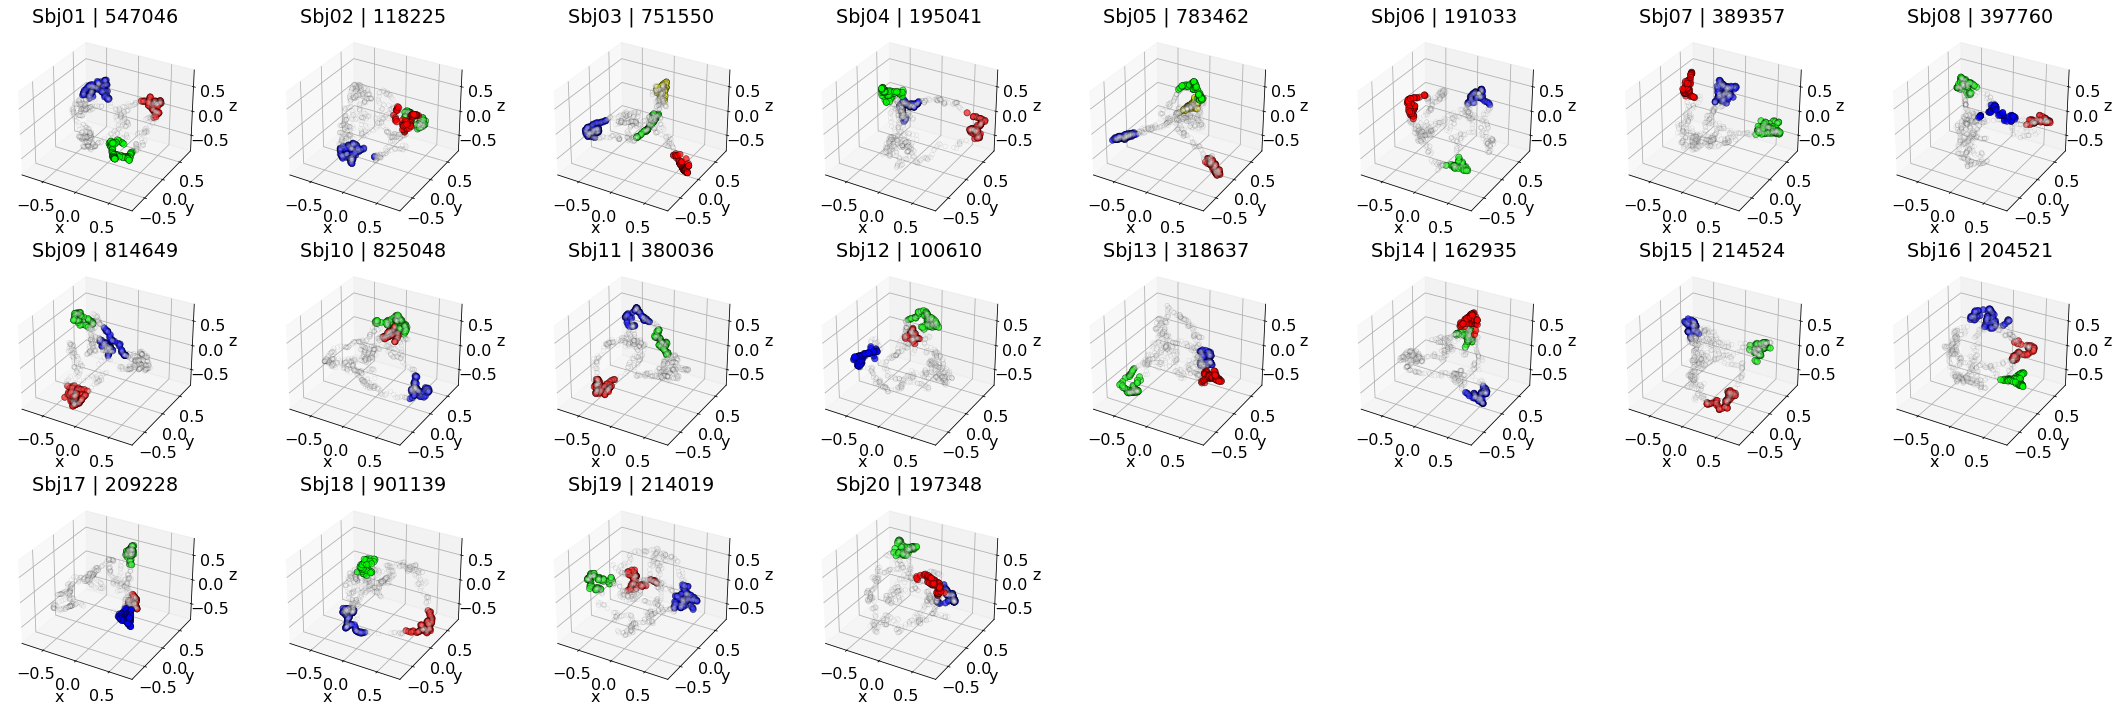

In [7]:
fig = plt.figure(figsize=(30,10))
plt.rcParams['font.size']=16
for s,SBJ in enumerate(HCP7T_Subjects):
    # PLOT ORIGINAL EMBEDDINGS (ALL WINDOWS IN WHITE)
    # ===============================================
    ax_3d = plt.subplot(3,8,s+1, projection='3d')
    surf = ax_3d.scatter3D(HCP7T_Embedds_DF[(SBJ,'x')],
                           HCP7T_Embedds_DF[(SBJ,'y')],
                           HCP7T_Embedds_DF[(SBJ,'z')],
                              s=20,
                              c='white', 
                              alpha=.1, 
                              edgecolors='black', 
                              linewidths=.5)
    ax_3d.set_xticks([-.5,0,.5]); ax_3d.set_xlim([-.8,.8]);ax_3d.set_xlabel('x')
    ax_3d.set_yticks([-.5,0,.5]); ax_3d.set_ylim([-.8,.8]);ax_3d.set_ylabel('y')
    ax_3d.set_zticks([-.5,0,.5]); ax_3d.set_zlim([-.8,.8]);ax_3d.set_zlabel('z')
    ax_3d.set_title('Sbj%02d | %s' % (s+1, SBJ))
    #ax_3d.set_aspect('equal')
        
    # SUPERIMPOSE THE CORNERS
    # =======================
    for k in np.arange(0,HCP7T_NClusters[s]):
        surf = ax_3d.scatter3D(HCP7T_Embedds_DF[SBJ][HCP7T_Embedds_DF[SBJ]['ManualClust_ID']==k+1]['x'],
                               HCP7T_Embedds_DF[SBJ][HCP7T_Embedds_DF[SBJ]['ManualClust_ID']==k+1]['y'],
                               HCP7T_Embedds_DF[SBJ][HCP7T_Embedds_DF[SBJ]['ManualClust_ID']==k+1]['z'],
                               s=40,
                               c=HCP7T_Embedds_DF[SBJ][HCP7T_Embedds_DF[SBJ]['ManualClust_ID']==k+1]['ManualClust_Color'], 
                               alpha=.7, 
                               edgecolors='black', 
                               linewidths=.5)
plt.tight_layout()

In [8]:
from scipy.io import loadmat

In [9]:
REF_Subject = HCP7T_Subjects[0]
Run         = 'Rest01'
WL_sec      = 30
INPUT_SUFFIX = 's_WS01_NROI0200_dF.mat'

In [10]:
WinInfo_DF = pd.DataFrame()
DATAFILE = '/data/SFIMJGC/PRJ_CognitiveStateDetection02/PrcsData_HCP7T/'+REF_Subject+'/D02_Rest/'+REF_Subject+'_'+Run+'_WL'+str(WL_sec).zfill(3)+INPUT_SUFFIX
DATAMAT  = loadmat(DATAFILE)
X                       = DATAMAT['CB']['snapshots'][0][0]
NWins                   = X.shape[0]
TR                      = DATAMAT['TR'][0][0]
WinInfo_DF['Name']      = DATAMAT['winInfo']['winNames'][0][0]
WinInfo_DF['Pure']      = DATAMAT['winInfo']['isValid'][0][0][0]
WinInfo_DF['Onset']     = (DATAMAT['winInfo']['onsetTRs'][0][0][0])*TR
WinInfo_DF['Offset']    = (DATAMAT['winInfo']['offsetTRs'][0][0][0])*TR
Wcolor                  = DATAMAT['winInfo']['color'][0][0]
WinInfo_DF['TaskColor'] = [ '#%02x%02x%02x' % (int(Wcolor[i,0]*255), int(Wcolor[i,1]*255), int(Wcolor[i,2]*255)) for i in np.arange(len(WinInfo_DF['Name']))]

print ('++ INFO: Number of Windows   : '+ str(NWins))
print ('++ INFO: Repetition Time [TR]: '+str(TR))
print ('++ INFO: Window Length [sec] : '+str(WL_sec))

++ INFO: Number of Windows   : 871
++ INFO: Repetition Time [TR]: 1
++ INFO: Window Length [sec] : 30


In [11]:
WL_trs      = int(WL_sec / TR)
WS_trs      = 1 

In [12]:
roi_ts         = pd.DataFrame(DATAMAT['origTS'])
roi_ts.columns = ['ROI'+str(r+1).zfill(3) for r in range(roi_ts.shape[1])]
roi_ts.index   = pd.timedelta_range(start='0',periods=roi_ts.shape[0],freq='{tr}L'.format(tr=TR*1000))

In [13]:
swc_r,swc_Z, winInfo = compute_SWC(roi_ts,WL_trs,WS_trs,window=None)

In [14]:
swc_Z.shape

(19900, 871)

In [15]:
mean_sorting_idx       = swc_r.mean(axis=1).sort_values(ascending=False).index

<AxesSubplot:ylabel='None-None'>

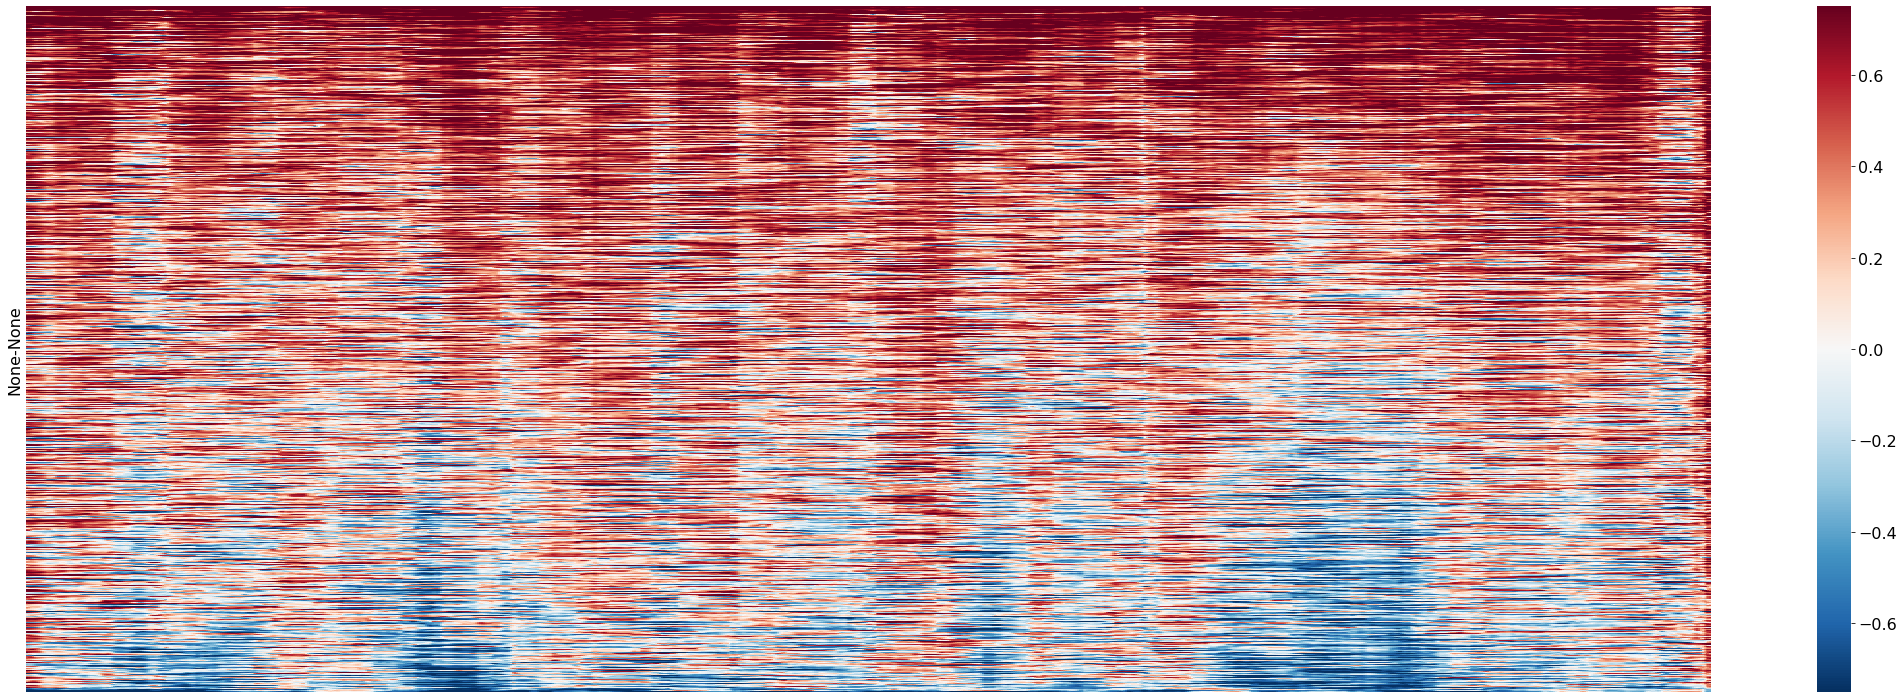

In [16]:
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,1,figsize=(30,10))
sns.heatmap(swc_r.loc[mean_sorting_idx], ax=ax,cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)

In [17]:
aux = HCP7T_Embedds_DF[HCP7T_Subjects[4]]
num_clusters = aux['ManualClust_ID'].max()
cl_info = {}
for cl in np.arange(num_clusters):
    cl_info[cl+1] = {}
    cl_info[cl+1]['onset'] = aux[aux['ManualClust_ID']==cl+1].index.min()
    cl_info[cl+1]['offset'] = aux[aux['ManualClust_ID']==cl+1].index.max()
    cl_info[cl+1]['width'] = cl_info[cl+1]['offset'] - cl_info[cl+1]['onset']
    cl_info[cl+1]['color'] = aux[aux['ManualClust_ID']==cl+1]['ManualClust_Color'].iloc[0]

In [18]:
cl_info

{1: {'onset': 777, 'offset': 870, 'width': 93, 'color': '#ff0000'},
 2: {'onset': 578, 'offset': 655, 'width': 77, 'color': '#00ff00'},
 3: {'onset': 285, 'offset': 399, 'width': 114, 'color': '#0000ff'},
 4: {'onset': 62, 'offset': 191, 'width': 129, 'color': '#ffff00'}}

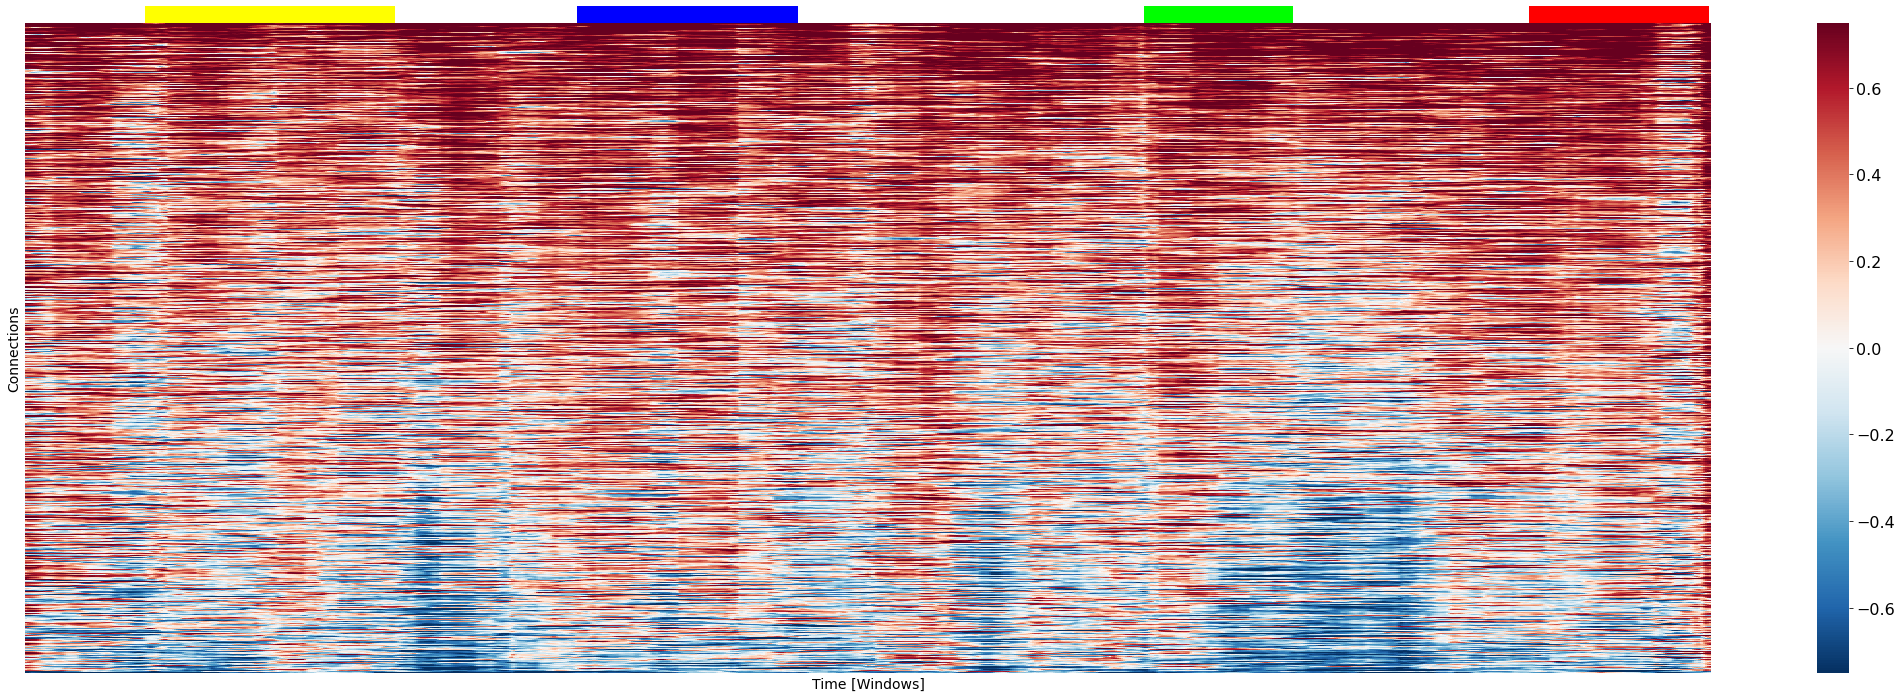

In [19]:
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots(1,1,figsize=(30,10))
plot1 = sns.heatmap(swc_r.loc[mean_sorting_idx].values, ax=ax,cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)
plot1.set_xlabel('Time [Windows]', fontsize=14)
plot1.set_ylabel('Connections',    fontsize=14)
for cl in np.arange(num_clusters):
    plot1.add_patch(Rectangle((int(cl_info[cl+1]['onset']), -501),  int(cl_info[cl+1]['width']), 500, fill=True, color=cl_info[cl+1]['color'], lw=0, clip_on=False))

/data/SFIMJGC_HCP7T/Apps/envs/embeddings3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


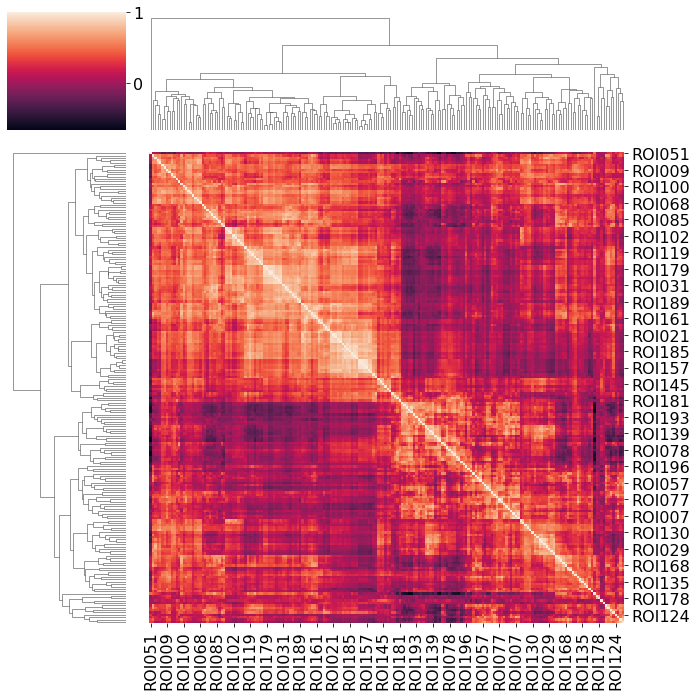

In [52]:
aux_fc = roi_ts.corr()
a      = sns.clustermap(aux_fc)
rois_sorted = ['ROI'+str(i+1).zfill(3) for i in a.dendrogram_row.reordered_ind]

<AxesSubplot:>

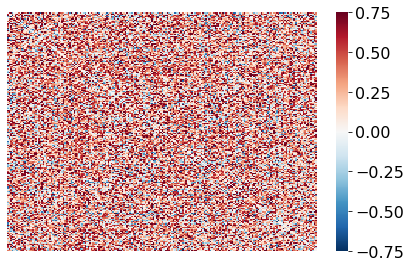

In [80]:
aux = pd.DataFrame(squareform(np.tanh(swc_Z.values[:,cl_info[2]['onset']:cl_info[2]['offset']].mean(axis=1))), index=['ROI'+str(i+1).zfill(3) for i in range(200)], columns=['ROI'+str(i+1).zfill(3) for i in range(200)])
sns.heatmap(aux.loc[rois_sorted,rois_sorted], cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)

In [46]:
aux = np.tanh(swc_Z.values[:,0:900].mean(axis=1))

In [47]:
fc   = np.zeros((200,200))
sel  = np.triu(np.ones(fc.shape),1).astype(bool)
fc[sel] = aux

/data/SFIMJGC_HCP7T/Apps/envs/embeddings3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


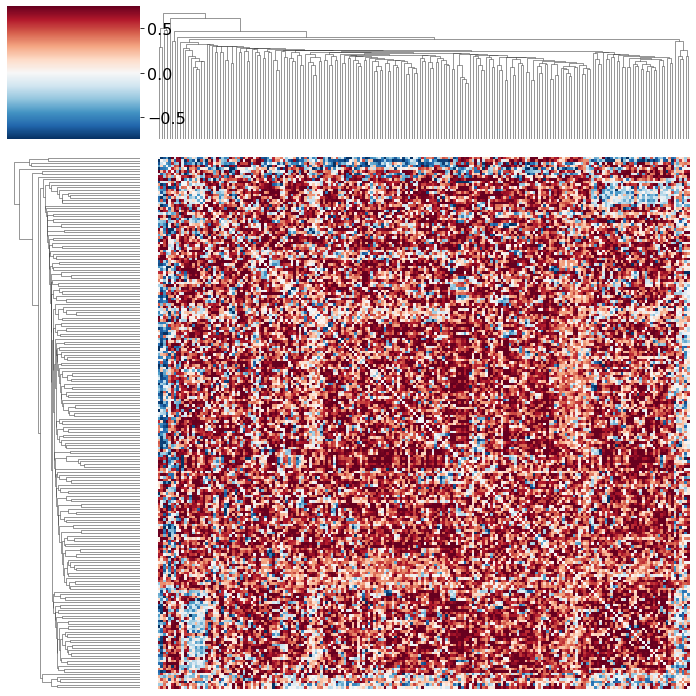

In [51]:
sns.clustermap(squareform(swc_r['W0000']), cmap='RdBu_r', vmin=-0.75, vmax=0.75, xticklabels=False, yticklabels=False)

In [ ]:
sel             = np.triu(np.ones(aux_fc.shape),1).astype(np.bool)
        aux_fc_v        = aux_fc.where(sel)

In [50]:
swc_r

W0000     W0001     W0002     W0003     W0004     W0005  \
ROI002 ROI001  0.565176  0.503967  0.351653  0.096034 -0.143457 -0.159757   
ROI003 ROI001  0.209105  0.303625  0.412235  0.467450  0.431272  0.371864   
       ROI002 -0.286709 -0.263212 -0.260095 -0.278909 -0.319371 -0.366969   
ROI004 ROI001  0.462176  0.481893  0.500168  0.459347  0.346497  0.309513   
       ROI002  0.343800  0.384986  0.444329  0.483588  0.467453  0.415444   
...                 ...       ...       ...       ...       ...       ...   
ROI200 ROI195  0.462930  0.469161  0.490555  0.529335  0.565343  0.574135   
       ROI196  0.802116  0.787194  0.764738  0.738065  0.705475  0.662436   
       ROI197  0.422095  0.462717  0.496958  0.467241  0.410836  0.358991   
       ROI198 -0.045900 -0.046992 -0.063971 -0.079637 -0.085866 -0.092290   
       ROI199  0.809776  0.826484  0.839539  0.846353  0.851598  0.859401   

                  W0006     W0007     W0008     W0009  ...     W0861  \
ROI002 ROI001 -0.027957  0.042376  0.015061 -0.029441  ...  0.126873   
ROI003 ROI001  0.345732  0.343097  0.338174  0.317663  ... -0.241978   
       ROI002 -0.375045 -0.331385 -0.266853 -0.195097  ...  0.133846   
ROI004 ROI001  0.376310  0.442706  0.438751  0.389276  ... -0.117248   
       ROI002  0.393637  0.437165  0.516028  0.586187  ...  0.438262   
...                 ...       ...       ...       ...  ...       ...   
ROI200 ROI195  0.549279  0.505007  0.462354  0.432341  ...  0.219957   
       ROI196  0.611144  0.564423  0.535449  0.526404  ...  0.528639   
       ROI197  0.317957  0.266755  0.192149  0.119043  ... -0.065734   
       ROI198 -0.106689 -0.125373 -0.132765 -0.122858  ...  0.640181   
       ROI199  0.862199  0.848038  0.828501  0.828888  ...  0.675495   

                  W0862     W0863     W0864     W0865     W0866     W0867  \
ROI002 ROI001  0.204833  0.262409  0.271665  0.271975  0.346489  0.477893   
ROI003 ROI001 -0.051851  0.143356  0.254241  0.287680  0.357426  0.521342   
       ROI002  0.239294  0.319394  0.319934  0.257474  0.260989  0.375532   
ROI004 ROI001  0.048993  0.117961  0.101817  0.102383  0.237728  0.429698   
       ROI002  0.500566  0.526223  0.516762  0.533528  0.601690  0.663913   
...                 ...       ...       ...       ...       ...       ...   
ROI200 ROI195  0.362857  0.390691  0.315149  0.311383  0.462513  0.603934   
       ROI196  0.481357  0.452689  0.421132  0.383982  0.435533  0.542988   
       ROI197  0.065179  0.086389 -0.016338 -0.115716 -0.094566  0.012969   
       ROI198  0.576353  0.521091  0.558190  0.621000  0.613141  0.556171   
       ROI199  0.689297  0.668379  0.593681  0.542038  0.624341  0.737922   

                  W0868     W0869     W0870  
ROI002 ROI001  0.577845  0.621227  0.638484  
ROI003 ROI001  0.646903  0.678111  0.633961  
       ROI002  0.449405  0.433604  0.377131  
ROI004 ROI001  0.551271  0.590010  0.585560  
       ROI002  0.693559  0.699325  0.697804  
...                 ...       ...       ...  
ROI200 ROI195  0.674617  0.697965  0.696606  
       ROI196  0.624799  0.661979  0.671202  
       ROI197  0.148761  0.253373  0.290439  
       ROI198  0.487937  0.448526  0.448516  
       ROI199  0.792805  0.796077  0.774844  

[19900 rows x 871 columns]

<AxesSubplot:>

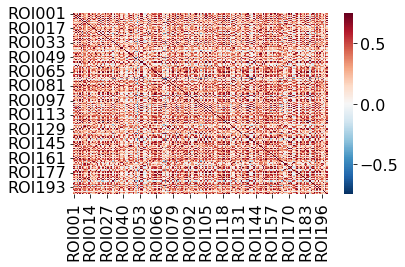

In [53]:
sns.heatmap(aux_fc,cmap='RdBu_r', vmin=-0.75, vmax=0.75)

In [59]:
rois_sorted = ['ROI'+str(i+1).zfill(3) for i in a.dendrogram_row.reordered_ind]

In [ ]:
def compute_SWC(ts,wl_trs,ws_trs,win_names=None,window=None):
    """
    This function will perform the following actions:
    1) Generate windows based on length, step and TR. This means computing window onsets and offsets
    2) Generate window names if those are not provided
    3) For each sliding window:
       * extract time series for all ROIs
       * multiply by the provided window shape
       * compute connectivity matrix
       * extract top triangle
       * apply fisher-transform
       
    INPUTS
    ------
    ts: (array) ROI timeseries in the form of a pd.DataFrame
    wl_trs: (int) window length in number of TRs
    ws_trs: (int) window step in number of TRs
    win_names: window labels as string array. If empty, labels will be generated automatically
    window: (np.array of length equal to wl_trs) window shape to apply
    
    OUTPUTS
    -------
    swc_r: (pd.Dataframe) sliding window connectivity matrix as Pearson's correlation
    swc_Z: (pd.Dataframe) sliding window connectivity matrix as Fisher's transform
    winInfo: (dict) containing window onsets, offsets, and labels.
    """

    [Nacq,Nrois] = ts.shape
    winInfo             = {'durInTR':int(wl_trs),'stepInTR':int(ws_trs)} # Create Window Information
    winInfo['numWins']  = int(np.ceil((Nacq-(winInfo['durInTR']-1))/winInfo['stepInTR'])) # Computer Number of Windows
    winInfo['onsetTRs'] = np.linspace(0,winInfo['numWins'],winInfo['numWins']+1, dtype='int')[0:winInfo['numWins']] # Compute Window Onsets
    winInfo['offsetTRs']= winInfo['onsetTRs'] + winInfo['durInTR']
    
    # Create Window Names
    if win_names is None:
        winInfo['winNames'] = ['W'+str(i).zfill(4) for i in range(winInfo['numWins'])]
    else:
        winInfo['winNames'] = win_names
    
    # Create boxcar window (if none provided)
    if window is None:
        window=np.ones((wl_trs,))
    
    # Compute SWC Matrix
    for w in range(winInfo['numWins']):
        aux_ts          = ts[winInfo['onsetTRs'][w]:winInfo['offsetTRs'][w]]
        aux_ts_windowed = aux_ts.mul(window,axis=0)
        aux_fc          = aux_ts_windowed.corr()
        sel             = np.triu(np.ones(aux_fc.shape),1).astype(np.bool)
        aux_fc_v        = aux_fc.where(sel)

        if w == 0:
            swc_r  = pd.DataFrame(aux_fc_v.T.stack().rename(winInfo['winNames'][w]))
        else:
            new_df = pd.DataFrame(aux_fc_v.T.stack().rename(winInfo['winNames'][w]))
            swc_r  = pd.concat([swc_r,new_df],axis=1)
    swc_Z = swc_r.apply(np.arctanh)
    
    return swc_r, swc_Z, winInfo